In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import pde_opt
from pde_opt.pde_model import PDEModel
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DPeriodic
from pde_opt.numerics.solvers import SemiImplicitFourierSpectral
from pde_opt.numerics.domains import Domain
from pde_opt.numerics.functions.mixer_mlp import Mixer2d

import equinox as eqx
import diffrax

In [3]:
Nx = Ny = 64
Lx = Ly = 0.01 * Nx

domain = Domain(
    (Nx, Ny),
    (
        (-Lx / 2, Lx / 2),
        (-Ly / 2, Ly / 2),
    ),
    "dimensionless",
)

In [4]:
opt_model = PDEModel(
    equation_type=CahnHilliard2DPeriodic,
    domain=domain,
    solver_type=SemiImplicitFourierSpectral,
)

In [10]:
params = {"kappa": 0.002, "mu": lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c), "D": lambda c: jnp.ones_like(c)}

solver_params = {"A": 0.5}

key = jax.random.PRNGKey(0)
y0 = jnp.clip(0.01 * jax.random.normal(key, (Nx, Ny)) + 0.5, 0.0, 1.0)
ts = jnp.linspace(0.0, 0.2, 100)

In [ ]:
sol = opt_model.solve(params, y0, ts, solver_params, dt0=0.000001, max_steps=1000000)

CPU times: user 14.8 s, sys: 151 ms, total: 15 s
Wall time: 15.1 s


Array([[[0.5162264 , 0.52025265, 0.49566406, ..., 0.49480334,
         0.48330784, 0.50675356],
        [0.50227386, 0.48819956, 0.49023268, ..., 0.49698278,
         0.5013313 , 0.49667186],
        [0.5157001 , 0.5057451 , 0.50723416, ..., 0.50017345,
         0.5040454 , 0.48928675],
        ...,
        [0.48956662, 0.49556184, 0.5028925 , ..., 0.5006537 ,
         0.5192058 , 0.49425107],
        [0.50859076, 0.4842574 , 0.5019254 , ..., 0.5161344 ,
         0.4887097 , 0.5007108 ],
        [0.4943401 , 0.49994966, 0.47428533, ..., 0.50954634,
         0.49342203, 0.5062125 ]],

       [[0.50034034, 0.50078666, 0.50123763, ..., 0.49922734,
         0.49954548, 0.49992073],
        [0.5004371 , 0.50082946, 0.50122607, ..., 0.49946535,
         0.49974155, 0.50006914],
        [0.50051886, 0.50085086, 0.5011868 , ..., 0.499707  ,
         0.49993536, 0.500209  ],
        ...,
        [0.49993888, 0.5004978 , 0.5010623 , ..., 0.49852967,
         0.49893537, 0.49941078],
        [0.5

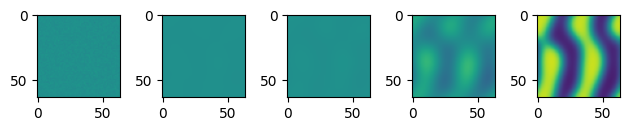

In [6]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("original_solution.png")

In [14]:
model = Mixer2d(
    (1, Nx, Ny),
    8,
    32,
    8,
    32,
    2,
    key=jax.random.PRNGKey(0),
)

model = eqx.filter_jit(model)

In [17]:
tmp = model(y0)

In [9]:
data = {}
data['ys'] = sol
data['ts'] = ts

inds = [[30,40,50], [50,60,70], [70,80,90]]

init_params = {
    "mu": model,
}

static_params = {
    "kappa": 0.002,
    "D": lambda c: jnp.ones_like(c),
}

solver_parameters = {
    "A": 0.5,
}

weights = {
    "mu": None
}

lambda_reg = 0.0


In [10]:
ts = jnp.linspace(0.0, 0.02, 100)
test_sol = opt_model.solve({**init_params, **static_params}, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

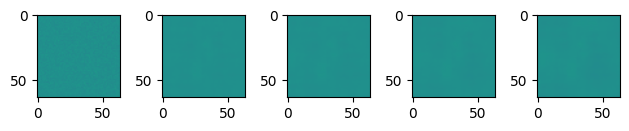

In [11]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(test_sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(test_sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(test_sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(test_sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(test_sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("test.png")

In [12]:
res = opt_model.train(data, inds, init_params, static_params, solver_parameters, weights, lambda_reg, method="mse", max_steps=10)

: 

In [16]:
opt_sol = opt_model.solve(res, y0, ts, solver_parameters, dt0=0.000001, max_steps=1000000)

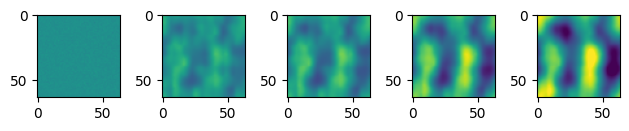

In [19]:
fig, ax = plt.subplots(1, 5)
ax[0].imshow(opt_sol[0], vmin=0.0, vmax=1.0)
ax[1].imshow(opt_sol[10], vmin=0.0, vmax=1.0)
ax[2].imshow(opt_sol[20], vmin=0.0, vmax=1.0)
ax[3].imshow(opt_sol[50], vmin=0.0, vmax=1.0)
ax[4].imshow(opt_sol[-1], vmin=0.0, vmax=1.0)
plt.tight_layout()
plt.savefig("optimized_solution.png")

